In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
IMAGE_SIZE = 224
BATCH_SIZE = 16
CHANNELS = 3
EPOCH = 50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
   "/kaggle/input/breast-cancer-data/augmented_data",
    shuffle=True,
    image_size =(IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 1966 files belonging to 4 classes.


In [4]:
class_names = dataset.class_names

# Initialize a dictionary to store class counts
class_counts = {class_name: 0 for class_name in class_names}

# Count the number of samples in each class
for images, labels in dataset:
    for label in labels:
        class_name = class_names[label]
        class_counts[class_name] += 1

# Print the class counts
for class_name, count in class_counts.items():
    print(f"Class {class_name}: {count} samples")

Class Benign: 488 samples
Class InSitu: 495 samples
Class Invasive: 493 samples
Class Normal: 490 samples


In [5]:
def get_dataset_partitions_tf(ds, train_split = 0.80, val_split =0.1 , test_split =0.1,shuffle = True ,shuffle_size = 10000 ):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)

    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds , val_ds,test_ds

In [6]:
train_ds,val_ds,test_ds = get_dataset_partitions_tf(dataset)

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

In [8]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size  =AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size  =AUTOTUNE)

#Model 2

In [9]:
import tensorflow as tf
import gc
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D, Activation, BatchNormalization, Dropout, LSTM, ConvLSTM2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Input,Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation, LSTM, ConvLSTM2D, Lambda, Reshape, BatchNormalization, Bidirectional
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint,TensorBoard,TerminateOnNaN, LearningRateScheduler, CSVLogger
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TerminateOnNaN
from tensorflow.keras.layers import Lambda, Reshape, DepthwiseConv2D, ZeroPadding2D, Add, MaxPooling2D,Activation, Flatten, Conv2D, Dense, Input, Dropout, Concatenate, GlobalMaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers.experimental import preprocessing
from keras.applications import imagenet_utils
from tensorflow.keras import layers
!pip install tensorflow-addons
import tensorflow_addons as tfa
import pandas as pd
import numpy as np
import random
import keras
import shutil
import pathlib
import itertools
import cv2
import os
import matplotlib.image as mpimg
import seaborn as sns

/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [10]:
    input_layer = Input(shape=(224,224,3))

    baseModel=keras.applications.EfficientNetV2S(
        include_top=False,
        weights="imagenet",
        input_tensor=input_layer
    )

    # Freeze the layers of the VGG19 model
    for layer in baseModel.layers[:100]:
        layer.trainable = False

    x = baseModel.output

    # LSTM layer
    x = Reshape((49,1280))(x)
    x = LSTM(512, activation="relu", return_sequences=True, trainable=False)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # FC layer
    x = Flatten(name="flatten")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # fc1 layer
    x = Dense(units=512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    




    # Output layer
    predictions = Dense(4,activation='softmax')(x)
    model4= Model(inputs = baseModel.inputs,outputs = predictions)



82420632/82420632 [==============================] - 0s 0us/step


In [11]:
model4.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 stem_conv (Conv2D)          (None, 112, 112, 24)         648       ['rescaling[0][0]']           
                                                                                                  
 stem_bn (BatchNormalizatio  (None, 112, 112, 24)         96        ['stem_conv[0][0]']           
 n)                                                                                           

In [12]:
model4.compile(optimizer = 'adam',loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
#checkpoint to save best model per epoch
model_filepath = "/kaggle/working/model4v2/model-{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpoint = ModelCheckpoint(
    filepath = model_filepath,
    monitor = 'val_accuracy',
    mode = 'max',
    save_best_only = True,
    verbose = 1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=15,
    verbose=1
)


# callbacks_list = [checkpoint, early_stopping]


In [14]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              verbose=1, mode='auto')

callbacks_list = [reduce_lr, early_stopping]


In [15]:
import time

# Record the start time
start_time = time.time()

In [16]:
history1 = model4.fit(
    train_ds,
    validation_data = val_ds,
    epochs =50,
    callbacks=callbacks_list
)

Epoch 1/50


2023-12-24 06:07:13.422779: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


98/98 [==============================] - 123s 362ms/step - loss: 2.0147 - accuracy: 0.5275 - val_loss: 1.2073 - val_accuracy: 0.4948 - lr: 0.0010
Epoch 2/50
98/98 [==============================] - 22s 220ms/step - loss: 1.2669 - accuracy: 0.5824 - val_loss: 1.4484 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/50
98/98 [==============================] - 22s 222ms/step - loss: 1.1229 - accuracy: 0.6137 - val_loss: 0.7374 - val_accuracy: 0.7812 - lr: 0.0010
Epoch 4/50
98/98 [==============================] - 22s 225ms/step - loss: 0.7430 - accuracy: 0.7331 - val_loss: 0.5133 - val_accuracy: 0.8490 - lr: 0.0010
Epoch 5/50
98/98 [==============================] - 22s 226ms/step - loss: 0.5409 - accuracy: 0.8059 - val_loss: 0.3399 - val_accuracy: 0.8854 - lr: 0.0010
Epoch 6/50
98/98 [==============================] - 22s 224ms/step - loss: 0.3788 - accuracy: 0.8595 - val_loss: 0.1522 - val_accuracy: 0.9635 - lr: 0.0010
Epoch 7/50
98/98 [==============================] - 22s 223ms/step - loss:

In [17]:
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Elapsed time: {elapsed_time} seconds")

Elapsed time: 1197.8714983463287 seconds


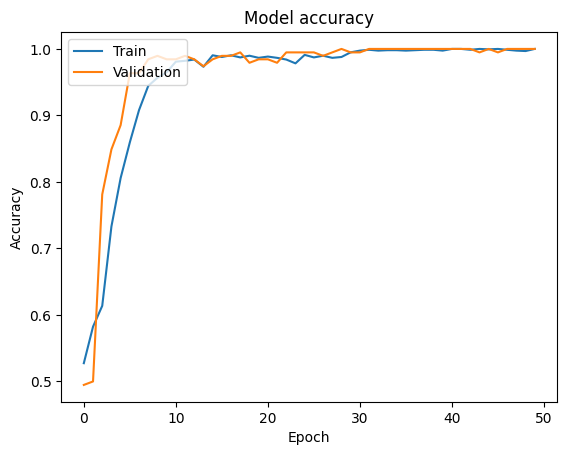

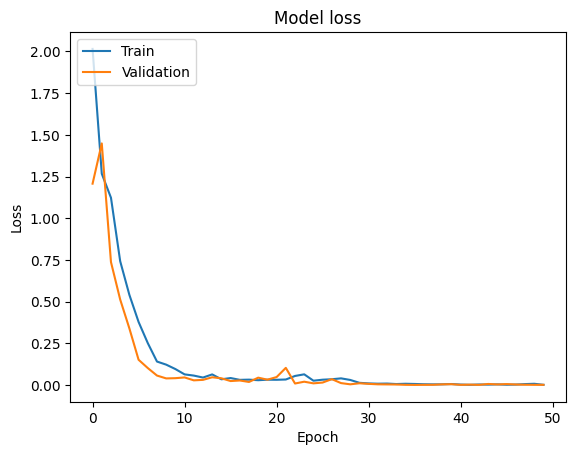

In [18]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [19]:
training_accuracy = history1.history['accuracy']
validation_accuracy = history1.history['val_accuracy']

# Print the final accuracy values (last epoch)
final_training_accuracy = training_accuracy[-1]
final_validation_accuracy = validation_accuracy[-1]

print(f'Final Training Accuracy: {final_training_accuracy * 100:.2f}%')
print(f'Final Validation Accuracy: {final_validation_accuracy * 100:.2f}%')

Final Training Accuracy: 100.00%
Final Validation Accuracy: 100.00%


In [20]:
test_ds = test_ds.map(lambda x, y: (x, y))

# Get predictions on the test set
predictions = model4.predict(test_ds)

# Convert predicted probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Extract true labels from the test dataset
true_labels_ds = test_ds.map(lambda x, y: y)
true_labels = np.concatenate(list(true_labels_ds.as_numpy_iterator()))

# Print classification report
from sklearn.metrics import classification_report

report = classification_report(true_labels, predicted_labels)
print(report)

13/13 [==============================] - 14s 72ms/step
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        57
           1       0.98      1.00      0.99        49
           2       0.96      1.00      0.98        47
           3       1.00      0.98      0.99        55

    accuracy                           0.99       208
   macro avg       0.98      0.99      0.99       208
weighted avg       0.99      0.99      0.99       208



In [21]:
class_names = dataset.class_names
class_names

['Benign', 'InSitu', 'Invasive', 'Normal']

1/1 [==============================] - 0s 70ms/step


<Figure size 1000x800 with 0 Axes>

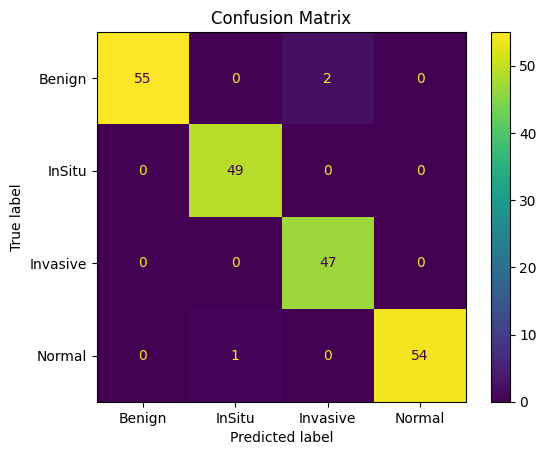

In [22]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Initialize variables
true_labels = []
predicted_labels = []

# Iterate over batches in the test dataset
for images_batch, labels_batch in test_ds:
    true_labels.extend(labels_batch.numpy())
    batch_predictions = model4.predict(images_batch)
    predicted_labels.extend(np.argmax(batch_predictions, axis=1))

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='viridis', values_format='d')
plt.title('Confusion Matrix')
plt.show()

In [23]:
train_accuracy = model4.evaluate(train_ds)

print(f"Hybrid Model's Accuracy on Train Dataset: {train_accuracy}")

98/98 [==============================] - 8s 77ms/step - loss: 0.0032 - accuracy: 0.9987
Hybrid Model's Accuracy on Train Dataset: [0.0031640806701034307, 0.9987228512763977]


first image to predict
actual label: Invasive
1/1 [==============================] - 0s 75ms/step
predicted label: Invasive


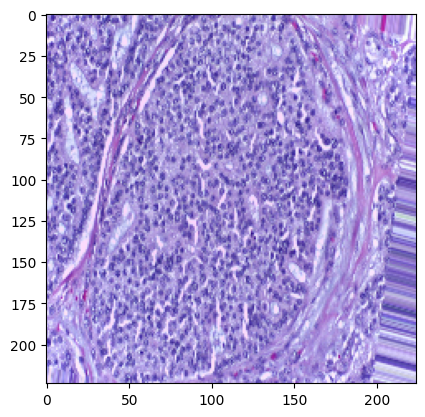

In [24]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model4.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [25]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 37ms/step


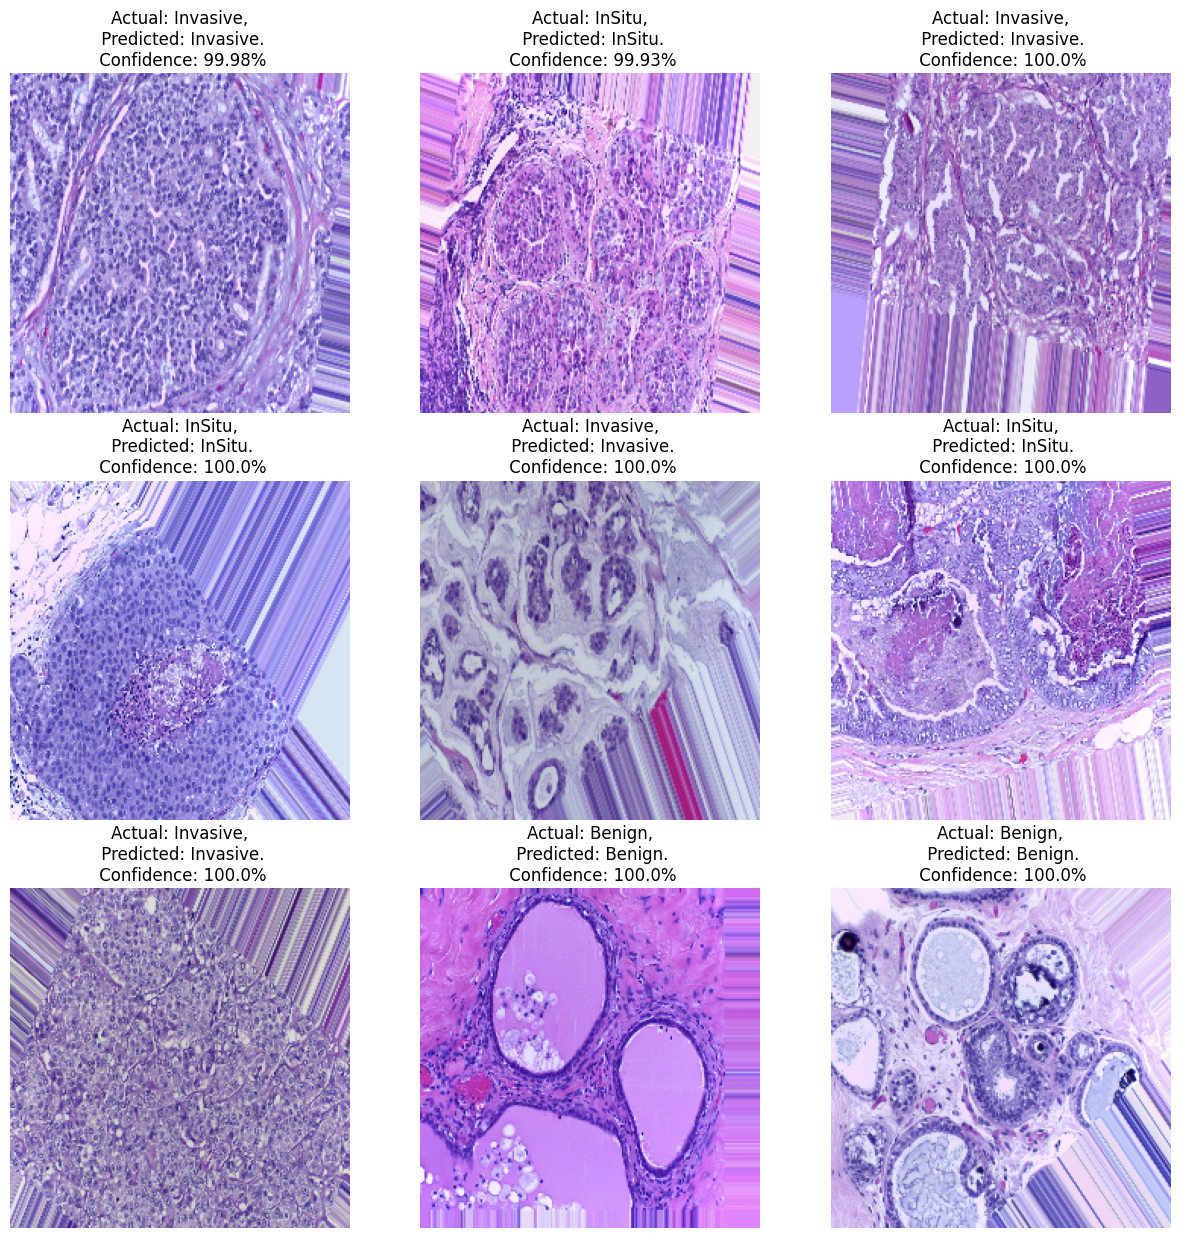

In [26]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model4, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [27]:
from sklearn.metrics import classification_report

# Assuming class_names is a list containing the names of your classes
class_names = class_names

# Get predictions on the test set
predictions = model4.predict(test_ds)

# Convert predicted probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Extract true labels from the test dataset
true_labels_ds = test_ds.map(lambda x, y: y)
true_labels = np.concatenate(list(true_labels_ds.as_numpy_iterator()))

# Print classification report with class names
report = classification_report(true_labels, predicted_labels, target_names=class_names)
print(report)

13/13 [==============================] - 1s 72ms/step
              precision    recall  f1-score   support

      Benign       1.00      0.96      0.98        57
      InSitu       0.98      1.00      0.99        49
    Invasive       0.96      1.00      0.98        47
      Normal       1.00      0.98      0.99        55

    accuracy                           0.99       208
   macro avg       0.98      0.99      0.99       208
weighted avg       0.99      0.99      0.99       208



In [29]:
history1.params

{'verbose': 1, 'epochs': 50, 'steps': 98}